In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
to_train=pd.read_csv('input/train_7r07part.csv')

In [4]:
to_train.head()

,id,college,rank,total_people,rank_percent,countM1,price_sumM1,price_avgM1,price_maxM1,price_minM1,...,地点263_max,地点263_min,地点263_median,地点840_count,地点840_sum,地点840_avg,地点840_max,地点840_min,地点840_median,label
0,160,6.0,613.0,1570.0,0.390446,24.0,115.86,4.827500,12.3,0.43,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,1000.0
1,27417,17.0,817.0,2051.0,0.398342,59.0,358.73,6.080169,23.8,0.01,...,5.6,3.6,4.6,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,0.0
2,14537,5.0,1022.0,2775.0,0.368288,86.0,244.39,2.841744,10.6,0.01,...,-1.0,-1.0,-1.0,28.0,119.0,4.25,6.0,3.0,4.0,1000.0
3,2396,9.0,2364.0,2933.0,0.806001,69.0,239.47,3.470580,21.4,-1.14,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,0.0
4,24354,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00,-1.000000,-1.0,-1.00,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,0.0


In [5]:
to_train['label'].value_counts()

0.0       6530
1000.0     515
1500.0     335
2000.0     239
Name: label, dtype: int64

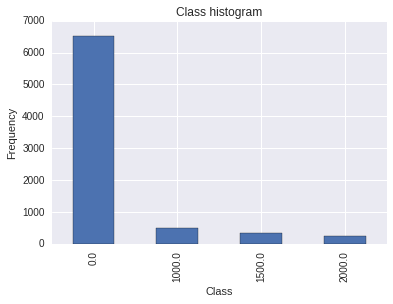

In [6]:
count_classes = pd.value_counts(to_train['label'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
X = to_train.ix[:, to_train.columns != 'label']
y = to_train.ix[:, to_train.columns == 'label']

In [8]:
def to_01(x):
    if x != 0:
        return 1
    else:
        return x

In [9]:
y['01']=y['label'].apply(lambda x : to_01(x))

/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
# 这里的采样方式，会造成数据分布变化 // resample to all data

from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.5, random_state = 42)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

('Number transactions train dataset: ', 3809)
('Number transactions test dataset: ', 3810)
('Total number of transactions: ', 7619)


In [11]:
train=X_train
train['label']=y_train['01']

train.to_csv('./input/train_binary.csv',index=False)
train=pd.read_csv('./input/train_binary.csv')

/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [12]:
number_records_fraud = len(train[train.label != 0])
fraud_indices = np.array(train[train.label != 0].index)

# Picking the indices of the normal classes
normal_indices = train[train.label == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = train.iloc[under_sample_indices,:]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'label']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'label']

# Showing ratio
print("Number of normal transactions: ", len(under_sample_data[under_sample_data.label == 0]))
print("Number of fraud transactions: ", len(under_sample_data[under_sample_data.label != 0]))
print("Total number of transactions in resampled data: ", len(under_sample_data))

('Number of normal transactions: ', 539)
('Number of fraud transactions: ', 539)
('Total number of transactions in resampled data: ', 1078)


In [13]:
#nice_feature=pd.read_csv('input/nice_feature.csv',header=None,index_col=0)

target = 'label'
IDcol = 'id'
ids = X_test['id'].values

all_feature = [x for x in train.columns if x not in [target]]
nice_feature=pd.read_csv('input/nice_feature.csv',header=None,index_col=0)
feature_imp_place20=pd.read_csv('input/feature_imp_place20.csv')

predictors = [ x for x in all_feature if (x in nice_feature.index)|(x in feature_imp_place20.feature.values)]

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

/home/kuhung/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


三个想法：

- 后threshold。多分类后再与threshold取交集。
- 将二分类结果（概率）作为新特征
- 先threshold。threshold改变数据分布后再多分类

指标：二分类F1

all-0: undersample: C = 0.1  threshold:0.54
            
1000-all:undersample: C = 1  threshold:0.48

1500-all:undersample: C = 10  threshold:0.8

2000-all:undersample: C = 1  threshold:0.7

In [15]:
best_c=0.1
threshold=0.54
predict_target='all'

lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_undersample[predictors],y_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test[predictors])

y_pred_undersample_proba[:,1]

X_test[predict_target]=y_pred_undersample_proba[:,1]

y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > threshold

X_test[predict_target]=y_test_predictions_high_recall

def to_score(x):
    if x ==True:
        return 1
    else:
        return 0

X_test[predict_target]=X_test[predict_target].apply(lambda x:to_score(x))

/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [44]:
test_plus=X_test

In [45]:
test_plus[target].value_counts()

0.0       3260
1000.0     259
1500.0     166
2000.0     125
Name: label, dtype: int64

In [46]:
test_plus[target]=y_test[target]

/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [47]:
test_plus=test_plus[test_plus['all']==1]

In [48]:
test_plus[target].value_counts()

0.0       852
1000.0    195
1500.0    129
2000.0     97
Name: label, dtype: int64

In [30]:
from xgboost import XGBClassifier

In [82]:
model=XGBClassifier(max_depth=4,objective='multi:softmax',n_estimators=100,seed=42)

In [32]:
validata=pd.read_csv('input/test_7r07part.csv')

In [34]:
best_c=0.1
threshold=0.54
predict_target='all'

lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_undersample[predictors],y_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(validata[predictors])

y_pred_undersample_proba[:,1]

validata[predict_target]=y_pred_undersample_proba[:,1]

y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > threshold

validata[predict_target]=y_test_predictions_high_recall

def to_score(x):
    if x ==True:
        return 1
    else:
        return 0

validata[predict_target]=validata[predict_target].apply(lambda x:to_score(x))

In [36]:
validata_plus=validata[validata['all']==1]

In [51]:
validata[target].value_counts()

0.0       2795
1000.0     226
1500.0     130
2000.0     115
Name: label, dtype: int64

In [52]:
validata_plus[target].value_counts()

0.0       722
1000.0    161
1500.0    105
2000.0     89
Name: label, dtype: int64

In [54]:
from imblearn.over_sampling import SMOTE

In [55]:
oversampler=SMOTE(random_state=0)
os_features,os_labels=oversampler.fit_sample(test_plus[predictors],test_plus[target])

/home/kuhung/anaconda2/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


In [65]:
os_features,os_labels=oversampler.fit_sample(os_features,os_labels)

/home/kuhung/anaconda2/lib/python2.7/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


In [66]:
os_labels_=pd.DataFrame(os_labels)

In [67]:
os_labels_[0].value_counts()

2000.0    852
1500.0    852
1000.0    852
0.0       852
Name: 0, dtype: int64

In [83]:
model.fit(os_features,os_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [84]:
predict_plus=model.predict(validata_plus[predictors])

In [85]:
validata_plus['predict']=predict_plus

/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [86]:
validata_plus['predict'].value_counts()

0.0       820
1000.0    139
1500.0     61
2000.0     57
Name: predict, dtype: int64

In [87]:
validata_plus.shape

(1077, 434)

In [88]:
validata.shape

(3266, 433)

In [89]:
binary_result=validata.merge(validata_plus,on='id',how='outer').fillna(0)

In [90]:
## Evaluation 
def f1_macro(label_truth, predictions):
    df=pd.DataFrame(columns=["subsidy_x","subsidy_y"])
    df.subsidy_y=predictions
    df.subsidy_x=np.array(label_truth)
    df.subsidy_y = df.subsidy_y.apply(lambda x:int(x))

    
    correct = df[df['subsidy_x'] == df['subsidy_y']]
    s = 0
    for i in [1000, 1500, 2000]:
        print '\n%d'%i
        if sum(df['subsidy_x'] == i)!=0:
            r = float(sum(correct['subsidy_y'] == i))/sum(df['subsidy_x'] == i)
            print 'Recall---%s'%r
        else: 
            r=0
        if sum(df['subsidy_y'] == i)!=0:
            p = float(sum(correct['subsidy_y'] == i))/sum(df['subsidy_y'] == i)        
            print 'Precision---%s'%p
        else:
            p=0
        if (r+p)!=0:
            f = r*p*2/(r+p)
            print 'F1---%s'%f
        if not np.isnan(f):
            s += (float(sum(df['subsidy_x'] == i))/df.shape[0])*f
    
    print '\nF1-macro---%s'%s
    return s

In [91]:
f1_macro(binary_result['label_x'],binary_result['predict'])


1000
Recall---0.119469026549
Precision---0.194244604317
F1---0.147945205479

1500
Recall---0.0846153846154
Precision---0.180327868852
F1---0.115183246073

2000
Recall---0.104347826087
Precision---0.210526315789
F1---0.139534883721

F1-macro---0.0197354409234


0.01973544092339006

In [16]:
best_c=1
threshold=0.48
predict_target='1000'

lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_undersample[predictors],y_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test[predictors])

y_pred_undersample_proba[:,1]

X_test[predict_target]=y_pred_undersample_proba[:,1]

'''
y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > threshold

X_test[predict_target]=y_test_predictions_high_recall

def to_score(x):
    if x ==True:
        return 1
    else:
        return 0

X_test[predict_target]=X_test[predict_target].apply(lambda x:to_score(x))

'''

/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'\ny_test_predictions_high_recall = y_pred_undersample_proba[:,1] > threshold\n\nX_test[predict_target]=y_test_predictions_high_recall\n\ndef to_score(x):\n    if x ==True:\n        return 1\n    else:\n        return 0\n\nX_test[predict_target]=X_test[predict_target].apply(lambda x:to_score(x))\n\n'

In [17]:
best_c=10
threshold=0.8
predict_target='1500'

lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_undersample[predictors],y_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test[predictors])

y_pred_undersample_proba[:,1]

X_test[predict_target]=y_pred_undersample_proba[:,1]

'''
y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > threshold

X_test[predict_target]=y_test_predictions_high_recall

def to_score(x):
    if x ==True:
        return 1
    else:
        return 0

X_test[predict_target]=X_test[predict_target].apply(lambda x:to_score(x))

'''

/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'\ny_test_predictions_high_recall = y_pred_undersample_proba[:,1] > threshold\n\nX_test[predict_target]=y_test_predictions_high_recall\n\ndef to_score(x):\n    if x ==True:\n        return 1\n    else:\n        return 0\n\nX_test[predict_target]=X_test[predict_target].apply(lambda x:to_score(x))\n\n'

In [18]:
best_c=1
threshold=0.7
predict_target='2000'

lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_undersample[predictors],y_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test[predictors])

y_pred_undersample_proba[:,1]

X_test[predict_target]=y_pred_undersample_proba[:,1]

'''
y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > threshold

X_test[predict_target]=y_test_predictions_high_recall

def to_score(x):
    if x ==True:
        return 1
    else:
        return 0

X_test[predict_target]=X_test[predict_target].apply(lambda x:to_score(x))

'''

/home/kuhung/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'\ny_test_predictions_high_recall = y_pred_undersample_proba[:,1] > threshold\n\nX_test[predict_target]=y_test_predictions_high_recall\n\ndef to_score(x):\n    if x ==True:\n        return 1\n    else:\n        return 0\n\nX_test[predict_target]=X_test[predict_target].apply(lambda x:to_score(x))\n\n'

In [19]:
X_test.shape

(5443, 435)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_test,y_test['label'],test_size = 0.5, random_state = 42)

In [21]:
train=X_train
train['label']=y_train

test=X_test

In [22]:

# tips：
# 尝试欠采样和smoth采样

# undersample
train.to_csv('input/train_half.csv',index=False)
train=pd.read_csv('input/train_half.csv')

number_records_fraud = len(train[train.label != 0])
fraud_indices = np.array(train[train.label != 0].index)

# Picking the indices of the normal classes
normal_indices = train[train.label == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = train.iloc[under_sample_indices,:]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'label']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'label']

# Showing ratio
print("Number of normal transactions: ", len(under_sample_data[under_sample_data.label == 0]))
print("Number of fraud transactions: ", len(under_sample_data[under_sample_data.label != 0]))
print("Total number of transactions in resampled data: ", len(under_sample_data))


# Oversample
Oversampling1000 = train.loc[train.label == 1000]
Oversampling1500 = train.loc[train.label == 1500]
Oversampling2000 = train.loc[train.label == 2000]
'''
for i in range(6):
    train = train.append(Oversampling1000)
for j in range(10):
    train = train.append(Oversampling1500)
for k in range(12):
    train = train.append(Oversampling2000)
'''
for i in range(5):
    train = train.append(Oversampling1000)
for j in range(8):
    train = train.append(Oversampling1500)
for k in range(10):
    train = train.append(Oversampling2000)
    
train = train[train['label'].notnull()]

('Number of normal transactions: ', 393)
('Number of fraud transactions: ', 393)
('Total number of transactions in resampled data: ', 786)


In [23]:
train.head()

,id,college,rank,total_people,rank_percent,countM1,price_sumM1,price_avgM1,price_maxM1,price_minM1,...,地点840_sum,地点840_avg,地点840_max,地点840_min,地点840_median,all,1000,1500,2000,label
0,30764,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00,-1.000000,-1.0,-1.00,...,-1.0,-1.000000,-1.0,-1.0,-1.0,0.189398,0.253657,0.266131,0.253680,0.0
1,17639,17.0,480.0,2051.0,0.234032,40.0,198.74,4.968500,31.4,-0.12,...,196.5,4.180851,7.0,1.0,4.0,0.533066,0.532759,0.532071,0.532753,0.0
2,4663,3.0,1438.0,2304.0,0.624132,154.0,458.81,2.979286,12.0,0.01,...,3.0,3.000000,3.0,3.0,3.0,0.783342,0.801125,0.804305,0.801130,1000.0
3,30657,18.0,193.0,193.0,1.000000,70.0,256.78,3.668286,25.6,-3.18,...,-1.0,-1.000000,-1.0,-1.0,-1.0,0.092106,0.094557,0.093463,0.094513,0.0
4,22621,8.0,1965.0,2830.0,0.694346,36.0,65.48,1.818889,25.0,0.01,...,8.4,8.400000,8.4,8.4,8.4,0.038584,0.041807,0.042328,0.041799,0.0


In [24]:
target = 'label'
IDcol = 'id'
ids = test['id'].values

all_feature = [x for x in train.columns if x not in [target]]
#predictors = [ x for x in train.columns if (x in all_feature) & (x !='0all')]
#predictors = [ x for x in all_feature if (x in all_feature)]

In [34]:
predictors = [ x for x in all_feature if (x in nice_feature.index) | (x =='all')| (x =='1000')| (x =='1500')| (x =='2000')]

In [35]:
predictors

['id',
 'rank_percent',
 'rest_sumM1',
 'rest_minM1',
 'price_sumM2',
 'price_sumM3',
 'rest_medianM3',
 'price_minM7',
 'rest_avgM8',
 'price_sumM9',
 'price_sumH7',
 'price_medianH8',
 'price_sumH9',
 'rest_minH9',
 'countH17',
 'price_avgH17',
 'price_maxH17',
 'change_count',
 'bathe_count',
 'bathe_sum',
 'all',
 '1000',
 '1500',
 '2000']

In [36]:
def f1_macro(label_truth, predictions):
    df=pd.DataFrame(columns=["subsidy_x","subsidy_y"])
    df.subsidy_y=predictions
    df.subsidy_x=np.array(label_truth)
    df.subsidy_y = df.subsidy_y.apply(lambda x:int(x))

    
    correct = df[df['subsidy_x'] == df['subsidy_y']]
    s = 0
    for i in [1000, 1500, 2000]:
        #print i
        r = float(sum(correct['subsidy_y'] == i))/sum(df['subsidy_x'] == i)
        #print r
        p = float(sum(correct['subsidy_y'] == i))/sum(df['subsidy_y'] == i)        
        #print p
        f = r*p*2/(r+p)
        if not np.isnan(f):
            s += (float(sum(df['subsidy_x'] == i))/df.shape[0])*f
    return s

In [37]:
import xgboost as xgb
model=xgb.XGBClassifier(seed=10,objective='multi:softmax')

In [38]:
model.fit(train[predictors],train[target])
prediction=model.predict(X_test[predictors])
f1_macro(y_test,prediction)

0.03048147230831718

In [39]:
0.029592512722876066#(原始特征)
0.029187772192533705#(纯概率)
0.030463249471639912#(阈值分类)
0.032220261329842625#(阈值调整后)

0.032220261329842625

In [40]:
feat_imp=pd.Series(model.booster().get_fscore()).sort_values(ascending=False)

In [41]:
feat_imp.count()

23

In [42]:
feat_imp

id                169
countH17          138
price_sumM3       130
all               126
price_sumH7       125
rest_minH9        124
price_maxH17      120
rest_sumM1        119
bathe_count       117
price_sumH9       113
price_avgH17      106
1000              104
rank_percent       95
price_medianH8     90
bathe_sum          90
rest_minM1         83
rest_medianM3      77
price_minM7        72
price_sumM2        69
price_sumM9        66
rest_avgM8         66
1500               52
change_count        7
dtype: int64